Desafio #6

Alumno: Yandri Uchuari Gallardo

Instalamos las librerías necesarias para ejecutar nuestro código.

In [ ]:
!pip -q install tensorflow gradio


Este bloque de código configura el entorno inicial para el desarrollo de un chatbot con redes neuronales. Se importan las librerías necesarias para manejo de datos, visualización y modelado con TensorFlow/Keras. Además, se establece una semilla aleatoria para asegurar reproducibilidad de resultados y se crea un directorio temporal donde se almacenarán los archivos y recursos del chatbot durante su ejecución.

In [ ]:
import os
import io
import re
import zipfile
import random
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Reproducibilidad
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Carpeta temporal de trabajo
WORKDIR = Path("./_tmp_chatbot")
WORKDIR.mkdir(parents=True, exist_ok=True)


2025-08-25 08:36:13.967848: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 08:36:13.968072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 08:36:14.001341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 08:36:14.777125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Este bloque descarga automáticamente el Cornell Movie Dialogs Corpus desde la web, lo guarda en la carpeta temporal y lo descomprime si aún no está extraído, dejando listo el conjunto de diálogos para su uso en el chatbot.

In [ ]:
CORNELL_URL = "https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
CORNELL_ZIP = WORKDIR / "cornell_movie_dialogs_corpus.zip"
CORNELL_DIR = WORKDIR / "cornell_movie_dialogs_corpus"

def descargar(url, destino: Path, desc="descargando"):
    if destino.exists():
        return destino
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(destino, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=desc) as bar:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
    return destino

# Descargar ZIP
descargar(CORNELL_URL, CORNELL_ZIP, desc="Cornell corpus")

# Extraer si no existe
if not CORNELL_DIR.exists():
    with zipfile.ZipFile(CORNELL_ZIP, "r") as z:
        z.extractall(WORKDIR)


Cornell corpus: 100%|██████████| 9.92M/9.92M [00:01<00:00, 6.38MB/s]


En este bloque se define la ruta del corpus Cornell y verifica que los archivos movie_lines.txt y movie_conversations.txt estén presentes en la carpeta, confirmando que los datos necesarios para el chatbot existen antes de procesarlos.

In [ ]:
from pathlib import Path

CORNELL_DIR = Path("./_tmp_chatbot/cornell movie-dialogs corpus")

lines_path = CORNELL_DIR / "movie_lines.txt"
convs_path = CORNELL_DIR / "movie_conversations.txt"

print("lines_path:", lines_path.exists())
print("convs_path:", convs_path.exists())


lines_path: True
convs_path: True


En este bloque se carga el corpus Cornell y se arma pares pregunta→respuesta listos para entrenar el chatbot: cargar_lineas crea un diccionario id→texto desde movie_lines.txt, cargar_conversaciones extrae secuencias de IDs desde movie_conversations.txt (usando ast.literal_eval y un fallback con regex para mayor robustez), luego recorre cada conversación para construir pares adyacentes (entrada/salida), e imprime conteos y un ejemplo de pares.

In [ ]:

import ast
import re

def cargar_lineas(path):
    """Devuelve dict: id_linea -> texto (desde movie_lines.txt)"""
    mapping = {}
    with open(path, "r", encoding="iso-8859-1") as f:
        for raw in f:
            parts = raw.split(" +++$+++ ")
            if len(parts) >= 5:
                line_id = parts[0].strip()
                text = parts[-1].strip()
                if line_id and text:
                    mapping[line_id] = text
    return mapping

def cargar_conversaciones(path):
    """Devuelve lista de listas de IDs (desde movie_conversations.txt)"""
    convs = []
    with open(path, "r", encoding="iso-8859-1") as f:
        for raw in f:
            parts = raw.strip().split(" +++$+++ ")
            if len(parts) != 4:
                continue
            ids_str = parts[-1].strip()
            # Formato esperado: "['L194', 'L195', ...]"
            if ids_str.startswith("[") and ids_str.endswith("]"):
                try:
                    ids = ast.literal_eval(ids_str)
                    if isinstance(ids, list) and all(isinstance(x, str) for x in ids):
                        convs.append(ids)
                        continue
                except Exception:
                    pass
            # Fallback: extraer IDs por regex si viniera mal formateado
            ids = re.findall(r"L\d+", ids_str)
            if ids:
                convs.append(ids)
    return convs

# Cargar estructuras
id2text = cargar_lineas(lines_path)
convs = cargar_conversaciones(convs_path)

# Construir pares adyacentes pregunta->respuesta
pares = []
for ids in convs:
    for i in range(len(ids) - 1):
        a = id2text.get(ids[i], "").strip()
        b = id2text.get(ids[i+1], "").strip()
        if a and b:
            pares.append((a, b))

print(f"líneas: {len(id2text)} | conversaciones: {len(convs)} | pares: {len(pares)}")
# Vista previa segura
if pares:
    print("Ejemplo de par:\nIN:", pares[0][0], "\nOUT:", pares[0][1])
else:
    print("No se generaron pares")



líneas: 304446 | conversaciones: 83097 | pares: 221282
Ejemplo de par:
IN: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again. 
OUT: Well, I thought we'd start with pronunciation, if that's okay with you.


En este bloque se normaliza y limpia los textos de los pares pregunta→respuesta: pasa todo a minúsculas, expande contracciones ( i'm → i am), elimina caracteres no deseados conservando letras, números y puntuación básica, y colapsa espacios. Luego aplica esta función a todos los pares, construye pares_limpios con los que quedaron válidos y muestra una vista previa de los primeros tres para verificar que la limpieza sea correcta.

In [ ]:
#limpieza simple y vista previa segura ---
import re

def limpiar(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\bi'm\b", "i am", s)
    s = re.sub(r"\bhe's\b", "he is", s)
    s = re.sub(r"\bshe's\b", "she is", s)
    s = re.sub(r"\bit's\b", "it is", s)
    s = re.sub(r"\bthat's\b", "that is", s)
    s = re.sub(r"\bwhat's\b", "what is", s)
    s = re.sub(r"\bwhere's\b", "where is", s)
    s = re.sub(r"\'ll\b", " will", s)
    s = re.sub(r"\'ve\b", " have", s)
    s = re.sub(r"\'re\b", " are", s)
    s = re.sub(r"\'d\b", " would", s)
    # Mantener letras/números y punt. básica
    s = re.sub(r"[^a-z0-9\s\.\,\!\?\']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

pares_limpios = []
if pares:
    for a, b in pares:
        la, lb = limpiar(a), limpiar(b)
        if la and lb:
            pares_limpios.append((la, lb))

print(f"pares_limpios: {len(pares_limpios)}")

# Vista previa segura
if pares_limpios:
    for i, (x, y) in enumerate(pares_limpios[:3]):
        print(f"IN[{i}]:", x)
        print(f"OUT[{i}]:", y)
        print("---")
else:
    print("Sin pares válidos tras limpieza")


pares_limpios: 221282
IN[0]: can we make this quick? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad. again.
OUT[0]: well, i thought we would start with pronunciation, if that is okay with you.
---
IN[1]: well, i thought we would start with pronunciation, if that is okay with you.
OUT[1]: not the hacking and gagging and spitting part. please.
---
IN[2]: not the hacking and gagging and spitting part. please.
OUT[2]: okay... then how 'bout we try out some french cuisine. saturday? night?
---


In [ ]:
SOS = "<sos>"
EOS = "<eos>"

max_len_in  = 15   # Ajustar a voluntad
max_len_out = 15

pares_filtrados = []
for a,b in pares_limpios:
    if 1 <= len(a.split()) <= max_len_in and 1 <= len(b.split()) <= max_len_out:
        pares_filtrados.append((a, f"{SOS} {b} {EOS}"))

len(pares_filtrados)


139713

In [ ]:
entradas = [a for a,_ in pares_filtrados]
salidas  = [b for _,b in pares_filtrados]

tokenizador = Tokenizer(oov_token="<unk>")
tokenizador.fit_on_texts(entradas + salidas)

vocab_size = len(tokenizador.word_index) + 1
vocab_size


34321

En este bloque se transforma los textos ya limpiados en secuencias numéricas listas para el modelo: convierte entradas y salidas en listas de índices usando el tokenizador, diferenciando entre entradas del encoder, entradas del decoder (sin <eos>) y salidas del decoder (sin <sos>). Luego aplica pad_sequences para igualar la longitud de todas las secuencias al máximo definido, generando tensores listos para el entrenamiento y mostrando sus dimensiones finales.

In [ ]:
X_enc = tokenizador.texts_to_sequences(entradas)                # encoder inputs
X_dec_in = tokenizador.texts_to_sequences([s.replace(EOS, "").strip() for s in salidas])  # decoder inputs (sin <eos>)
y_dec = tokenizador.texts_to_sequences([s.replace(SOS, "").strip() for s in salidas])     # decoder targets (sin <sos>)

X_enc = pad_sequences(X_enc, maxlen=max_len_in, padding="post")
X_dec_in = pad_sequences(X_dec_in, maxlen=max_len_out, padding="post")
y_dec = pad_sequences(y_dec, maxlen=max_len_out, padding="post")

X_enc.shape, X_dec_in.shape, y_dec.shape


((139713, 15), (139713, 15), (139713, 15))

In [ ]:
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = WORKDIR / "glove.6B.zip"
GLOVE_DIR = WORKDIR / "glove.6B"
EMB_DIM = 100  # 50/100/200/300 disponibles en glove.6B

# Descargar y extraer
descargar(GLOVE_URL, GLOVE_ZIP, desc="GloVe 6B")
if not GLOVE_DIR.exists():
    with zipfile.ZipFile(GLOVE_ZIP, "r") as z:
        z.extractall(WORKDIR)


GloVe 6B: 100%|██████████| 862M/862M [09:16<00:00, 1.55MB/s]  


En este bloque se integra embeddings preentrenados de GloVe al modelo: primero carga el archivo glove.6B.100d.txt y construye un diccionario embeddings_index que mapea cada palabra a su vector de 100 dimensiones. Luego crea la embedding_matrix del tamaño del vocabulario del tokenizador y asigna a cada palabra su vector correspondiente cuando existe en GloVe.

In [ ]:
# Cargar el archivo glove.6B.100d.txt
glove_txt = "/home/ose/LPN_CEIA_a1906/Desafio 6/_tmp_chatbot/glove.6B.100d.txt"
embeddings_index = {}
with open(glove_txt, "r", encoding="utf-8") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Crear embedding matrix
embedding_matrix = np.zeros((vocab_size, EMB_DIM), dtype="float32")
for word, idx in tokenizador.word_index.items():
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec

np.mean(embedding_matrix != 0), embedding_matrix.shape

(np.float64(0.8075813641793654), (34321, 100))

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_len_in,), name="encoder_inputs")
enc_emb = Embedding(
    input_dim=vocab_size,
    output_dim=EMB_DIM,
    weights=[embedding_matrix],
    input_length=max_len_in,
    trainable=False,
    name="emb_encoder"
)(encoder_inputs)
encoder_gru = GRU(256, return_state=True, name="gru_encoder")
_, enc_state = encoder_gru(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_len_out,), name="decoder_inputs")
dec_emb = Embedding(
    input_dim=vocab_size,
    output_dim=EMB_DIM,
    weights=[embedding_matrix],
    input_length=max_len_out,
    trainable=False,
    name="emb_decoder"
)(decoder_inputs)
decoder_gru = GRU(256, return_sequences=True, return_state=True, name="gru_decoder")
dec_outputs, _ = decoder_gru(dec_emb, initial_state=enc_state)
dec_dense = TimeDistributed(Dense(vocab_size, activation="softmax"), name="proy")
dec_probs = dec_dense(dec_outputs)

modelo_entrenamiento = Model([encoder_inputs, decoder_inputs], dec_probs)
modelo_entrenamiento.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=[]
)
modelo_entrenamiento.summary()


/home/ose/LPN_CEIA_a1906/yandri/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1756129648.150004 2451309 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1756129648.153545 2451309 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_encoder         │ (None, 15, 100)   │  3,432,100 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_decoder         │ (None, 15, 100)   │  3,432,100 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_encoder (GRU)   │ [(None, 256),     │    274,944 │ emb_encoder[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_decoder (GRU)   │ [(None, 15, 256), │    274,944 │ emb_decoder[0][0… │
│                     │ (None, 256)]      │            │ gru_encoder[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proy                │ (None, 15, 34321) │  8,820,497 │ gru_decoder[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,234,585 (61.93 MB)

 Trainable params: 9,370,385 (35.75 MB)

 Non-trainable params: 6,864,200 (26.18 MB)

En este bloque se entrena al modelo

Epoch 1/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 944s 958ms/step - loss: 2.8600 - val_loss: 2.5596
Epoch 2/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 932s 949ms/step - loss: 2.4033 - val_loss: 2.4275
Epoch 3/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 937s 954ms/step - loss: 2.2789 - val_loss: 2.3839
Epoch 4/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 950s 967ms/step - loss: 2.1921 - val_loss: 2.3678
Epoch 5/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 951s 968ms/step - loss: 2.1204 - val_loss: 2.3627
Epoch 6/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 952s 968ms/step - loss: 2.0547 - val_loss: 2.3634
Epoch 7/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 951s 968ms/step - loss: 1.9975 - val_loss: 2.3665
Epoch 8/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 952s 969ms/step - loss: 1.9477 - val_loss: 2.3708
Epoch 9/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 949s 965ms/step - loss: 1.9058 - val_loss: 2.3770
Epoch 10/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 951s 967ms/step - loss: 1.8705 - val_loss: 2.3825
Epoch 11/20
983/983 ━━━━━━━━━━━━━━━━━━━━ 952s 968ms/step - loss: 1.8399 - val_loss: 2.3890
Epoch 12

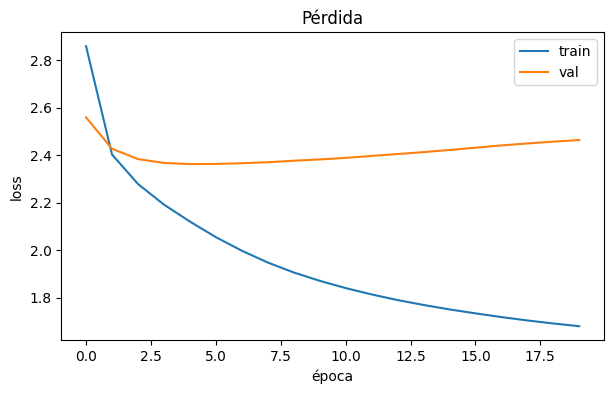

In [ ]:
# y_dec necesita shape (N, T, 1) o (N, T) con dtype int para sparse loss
y_target = np.expand_dims(y_dec, -1)  # (N, T, 1)

hist = modelo_entrenamiento.fit(
    [X_enc, X_dec_in],
    y_target,
    batch_size=128,
    epochs=20,            # puedes subirlo si tienes tiempo/GPU
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(7,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.legend(); plt.title("Pérdida"); plt.xlabel("época"); plt.ylabel("loss"); plt.show()


En este bloque define la arquitectura de inferencia del chatbot: se construye un modelo encoder_infer que toma la secuencia de entrada y produce el estado oculto final, y un modelo decoder_infer que, dado un token de entrada y el estado anterior, genera la probabilidad de la siguiente palabra junto con el nuevo estado.

In [ ]:
# Modelo encoder para inferencia (genera estado)
encoder_infer = Model(encoder_inputs, enc_state)

# Partes del decoder para inferencia
state_input = Input(shape=(256,), name="estado_infer")
dec_emb_inf = modelo_entrenamiento.get_layer("emb_decoder")(decoder_inputs)
dec_outputs_inf, state_out_inf = decoder_gru(dec_emb_inf, initial_state=state_input)
dec_probs_inf = dec_dense(dec_outputs_inf)
decoder_infer = Model([decoder_inputs, state_input], [dec_probs_inf, state_out_inf])


En este bloque genera respuestas en inferencia: mapea índices a palabras, decodifica una secuencia hasta <eos> y define responder(frase), que limpia el texto, lo vectoriza, obtiene el estado del encoder, y luego usa el decoder paso a paso con búsqueda greedy (argmax) para predecir el siguiente token hasta completar la salida,  finalmente devuelve la frase decodificada y muestra una respuesta para la siguiente pregunta “Hello, how are you?”.

In [ ]:
idx2word = {idx: w for w, idx in tokenizador.word_index.items()}

def decodificar(indices):
    palabras = []
    for idx in indices:
        if idx == 0:
            continue
        w = idx2word.get(idx, "<unk>")
        if w == EOS:
            break
        palabras.append(w)
    return " ".join(palabras)

def responder(frase, max_tokens=max_len_out):
    # Preprocesar entrada
    s = limpiar(frase)
    seq = tokenizador.texts_to_sequences([s])
    seq = pad_sequences(seq, maxlen=max_len_in, padding="post")

    # Estado inicial del decoder
    est = encoder_infer.predict(seq, verbose=0)

    # <sos> como primer token de decoder
    dec_in = tokenizador.texts_to_sequences([[SOS]])[0]
    dec_seq = pad_sequences([dec_in], maxlen=max_len_out, padding="post")

    salida_tokens = []
    for t in range(max_tokens):
        probs, est = decoder_infer.predict([dec_seq, est], verbose=0)
        # Tomar el último paso temporal generado (posición t)
        paso_t = probs[:, t, :]
        idx = int(np.argmax(paso_t, axis=-1)[0])
        salida_tokens.append(idx)

        if idx2word.get(idx) == EOS:
            break

        # Actualizar entrada del decoder en la posición t+1
        if t+1 < max_len_out:
            dec_seq[0, t+1] = idx

    return decodificar(salida_tokens)

print(responder("Hello, how are you?"))


be mad eos eos eos eos eos eos eos eos eos eos eos eos eos


En este bloque levanta una interfaz web usando Gradio para conversar con el modelo: define ui_responder, crea la Interface con un Textbox y un Slider, muestra título y descripción, y finalmente lanza la app con demo.launch() para que el chatbot responda a la pregunta del usuario.

In [ ]:
import gradio as gr

def ui_responder(entrada, temperatura=1.0):
    
    return responder(entrada)

demo = gr.Interface(
    fn=ui_responder,
    inputs=[
        gr.Textbox(label="Tu mensaje"),
        gr.Slider(0.5, 1.5, value=1.0, step=0.1, label="Temperatura (opcional)")
    ],
    outputs="text",
    title="Chatbot Seq2Seq (GRU + GloVe)",
    description="Entrenado automáticamente a partir del Cornell Movie Dialogs Corpus."
)

demo.launch()


/home/ose/LPN_CEIA_a1906/yandri/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


![Chat](Chat_capture.jpeg)